### Downloading CIFAR-10 using torchvision

In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
import PIL
import random as rnd
import seaborn as sns
from sklearn.manifold import TSNE

import sys
np.set_printoptions(threshold=sys.maxsize)

np.random.seed(42)


dataset = torchvision.datasets.CIFAR10(root='./',download=True)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to ./


<PIL.Image.Image image mode=RGB size=32x32 at 0x7FA4ADF68590> 5
(32, 32)


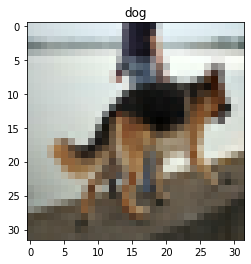

In [ ]:
labels_map = {
    0: "plane",
    1: "car",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck",
}

image_indices = np.zeros((10, 3))
labels = np.array(dataset.targets)
# taking first five images of each class
for i in range(10):
  indices = np.where(labels == i)[0]
  image_indices[i] = np.array(indices[0:3])

sample_idx = torch.randint(len(dataset), size=(1,)).item()
img, label = dataset[sample_idx]
print(img, label)
plt.title(labels_map[label])
plt.imshow(img)

I = np.array(img)
print(I[:,:, 0].shape)

### Activation Functions

In [ ]:
def sigmoid(I):
  I = -1 * I
  return 1/(1 + np.exp(I))

In [ ]:
def reLU(I):
  I[I < 0] = 0
  return I

In [ ]:
def tanh(I):
  return (np.exp(I) - np.exp(-1 * I))/(np.exp(I) + np.exp(-1 * I))
  
  
  # a = (np.exp(I) - np.exp(-1 * I))/(np.exp(I) + np.exp(-1 * I))
  # da = 1 - a**2
  # return a, da

In [ ]:
def PreLU(I, a=0.01):
  I[I <= 0] = a * I[I <= 0]
  return I

### Convolution 

In [ ]:
def convolution1(I, kernel, padding=True, stride=1, activation='sigmoid'):

  N1, M1, C = I.shape
  N2, M2, _ = kernel.shape

  result = np.zeros((N1, M1))

  if padding == True:
    padding = N2 // 2
  else:
    padding = 0
  # zero padding
  padded = np.zeros((N1 + padding * 2, M1 + padding * 2, C))
  padded[padding:-padding, padding:-padding, :] = I


  # for faster calculations
  for i in range(padding, N1 + padding):
    if i % stride == 0:
      for j in range(padding, M1 + padding):
        if j % stride == 0:
          result[i - padding, j - padding] = (np.multiply(kernel, padded[i - padding: i + padding + 1, j - padding: j + padding + 1, :]).sum())

  if activation == 'sigmoid':
    result = sigmoid(result) 
  elif activation == 'relu':
    result = reLU(result)
  elif activation == 'prelu':
    result = PreLU(result) 
  elif activation == 'tanh':
    result = tanh(result) 

  return result

In [ ]:
def convolution2(I, kernel, padding=True, stride=1, activation='sigmoid'):

  _, N1, M1 = I.shape
  _, N2, M2 = kernel.shape

  result = np.zeros((N1, M1))

  if padding == True:
    padding = N2 // 2
  else:
    padding = 0
  # zero padding
  padded = np.zeros((I.shape[0], N1 + padding * 2, M1 + padding * 2))
    
  for i in range(I.shape[0]):
    padded[i, padding:-padding, padding:-padding] = I[i, :, :]
    
  # for faster calculations
  for i in range(padding, N1 + padding):
    if i % stride == 0:
      for j in range(padding, M1 + padding):
        if j % stride == 0:
          result[i - padding, j - padding] = (np.multiply(kernel, padded[:, i - padding: i + padding + 1, j - padding: j + padding + 1]).sum())

  if activation == 'sigmoid':
    result = sigmoid(result) 
  elif activation == 'relu':
    result = reLU(result)
  elif activation == 'prelu':
    result = PreLU(result) 
  elif activation == 'tanh':
    result = tanh(result) 
  
  return result

The convolution layers have been implemented in the later functions called `L1()` and `L3()`.

###Kernels

In [ ]:
def gaussianKernel1(kernel_size):

  M = np.zeros((kernel_size, kernel_size))
  sigma = rnd.uniform(0.5, 5)

  range_beg = -1 * int(kernel_size/2)
  range_end = range_beg + kernel_size

  for x in range(range_beg, range_end):
    for y in range(range_beg, range_end):
      numerator = np.exp(-((x**2) + (y**2)) / (2 * (sigma**2)))
      denominator = 2 * np.pi * (sigma**2)
      M[x - range_beg, y - range_beg] = numerator / denominator

  kernel = np.stack((M, M, M))

  return kernel

def DoG1(kernel_size):
  kernel1 = gaussianKernel1(kernel_size)
  kernel2 = gaussianKernel1(kernel_size)
  return kernel1 - kernel2

In [ ]:
def gaussianKernel2(kernel_size):

  M = np.zeros((kernel_size, kernel_size))
  sigma = rnd.uniform(0.5, 5)

  range_beg = -1 * int(kernel_size/2)
  range_end = range_beg + kernel_size

  for x in range(range_beg, range_end):
    for y in range(range_beg, range_end):
      numerator = np.exp(-((x**2) + (y**2)) / (2 * (sigma**2)))
      denominator = 2 * np.pi * (sigma**2)
      M[x - range_beg, y - range_beg] = numerator / denominator

  # stack 16 times
  kernel = [M, M, M, M, M, M, M, M, M, M, M, M, M, M, M, M]
  kernel = np.array(kernel)

  return kernel

def DoG2(kernel_size):
  kernel1 = gaussianKernel2(kernel_size)
  kernel2 = gaussianKernel2(kernel_size)
  return kernel1 - kernel2

In [ ]:
def randomKernel1(kernel_size):
  M = np.random.rand(kernel_size, kernel_size)
  kernel = [M, M, M]
  kernel = np.array(kernel)
  return kernel

def randomKernel2(kernel_size):
  M = np.random.rand(kernel_size, kernel_size)
  # stack 16 times
  kernel = [M, M, M, M, M, M, M, M, M, M, M, M, M, M, M, M]
  kernel = np.array(kernel)
  return kernel

### Pooling 

In [ ]:
def pooling(I, pool_size, stride=2, poolType='max'):

  height, width = I.shape

  # zero padding
  padding = pool_size // 2
  # padded = np.pad(I, padding, mode='constant')

  padded = np.zeros((height + padding * 2, width + padding * 2))
  padded[padding:-padding, padding:-padding] = I

  heightRes = int((height - pool_size)/stride + 1)
  widthRes = int((width - pool_size)/stride + 1)
  output = np.zeros((heightRes, widthRes))


  for i in range(0, height, stride):
    if i + pool_size > height:
      break
    for j in range(0, width, stride):
      if j + pool_size > width:
        break
      temp = I[i: i + pool_size, j: j + pool_size]
      if poolType == 'avg':
        output[int(i/stride), int(j/stride)] = np.mean(temp)
      elif poolType == 'min':
        output[int(i/stride), int(j/stride)] = np.amin(temp)
      else:
        output[int(i/stride), int(j/stride)] = np.amax(temp)
  
  return output

### Flattening

In [ ]:
def flatten(I):
  return np.ravel(I).reshape(I.shape[0], -1)

The pooling layers have been implemented in the later functions called `L2()` and `L4()`.

### Layer 1: 16 Kernels

In [ ]:
def L1(I, kernelType="Gaussian", k_no=16, k_size=3, padding=True, stride=1, activation='sigmoid'):
  kernels_1 = []
  layer1 = []

  if kernelType == "Random":
    for i in range(k_no):
      kernel = randomKernel1(k_size)
      kernels_1.append(kernel)
      layer1.append(convolution1(I, kernel, padding, stride, activation))


    L_1 = np.array(layer1)
    return L_1

  for i in range(k_no):
    kernel = DoG1(k_size)
    kernels_1.append(kernel)
    layer1.append(convolution1(I, kernel, padding, stride, activation))

  L_1 = np.array(layer1)
  return L_1


### Layer 2: Max Pool

In [ ]:
def L2(L_1, poolSize=2, stride=2, poolType='max'):
  layer2 = []
  for img in L_1:
    layer2.append(pooling(img, poolSize, stride, poolType))

  L_2 = np.array(layer2)
  return L_2

### Layer 3: 8 Kernels

In [ ]:
def L3(L_2, kernelType="Gaussian", k_no=8, k_size=3, padding=True, stride=1, activation='sigmoid'):
  kernels = []
  layer3 = []

  if kernelType == "Random":
    for i in range(k_no):
      kernel = DoG2(k_size)
      kernels.append(kernel)
      layer3.append(convolution2(L_2, kernel, padding, stride, activation))
      

    L_3 = np.array(layer3)
    # print(L_3.shape)
    return L_3

  for i in range(k_no):
    kernel = DoG2(k_size)
    kernels.append(kernel)
    layer3.append(convolution2(L_2, kernel, padding, stride, activation))

  L_3 = np.array(layer3)
  # print(L_3.shape)
  return L_3

### Layer 4: Max Pool

In [ ]:
def L4(L_3, poolSize=2, stride=2, poolType='max'):
  layer4 = []
  for img in L_3:
    layer4.append(pooling(img, poolSize, stride, poolType))

  L_4 = np.array(layer4)
  # print(L_4.shape)
  return L_4

### Layer 5: Flattening

In [ ]:
def L5(L_4):
  L_5 = L_4.flatten()
  return L_5

### Layer 6: MLP

In [ ]:
class MLP():
  def __init__(self, input=512, hidden=512, output=10, activation='sigmoid'):

    self.input = input 
    self.hidden = hidden
    self.output = output
    self.activation = activation

    self.w1 = np.random.randn(input, hidden) # weights for the hidden layer
    self.w2 = np.random.randn(hidden, output) # weights for the output layer
    self.b1 = np.random.randn(1, hidden) # bias for the hidden layer
    self.b2 = np.random.randn(1, output) # bias for the output layer

    self.z1 = None
    self.a1 = None # activation of the hidden layer
    self.z2 = None
    self.a2 = None # activation of output
  
  def forward(self, X):
    self.z1 = np.dot(X, self.w1) + self.b1
    self.a1 = reLU(self.z1)

    self.z2 = np.dot(self.a1, self.w2) + self.b2
    # self.a2 = reLU(self.z2)

    if self.activation == 'sigmoid':
      self.a2 = sigmoid(self.z2) 
    elif self.activation == 'relu':
      self.a2 = reLU(self.z2)
    elif self.activation == 'prelu':
      self.a2 = PreLU(self.z2) 
    elif self.activation == 'tanh':
      self.a2 = tanh(self.z2) 

    return self.a2

def L6(L_5):
  layer6 = MLP()
  L_6 = layer6.forward(L_5)
  # print(L_6.shape)
  return L_6


### Forward Pass

In [1]:
def forward(I, plot=False, kernel="Gaussian", k1_no=16, k2_no=8):

  plt.imshow(I)
  plt.title("Input Image")

  # layer 1
  L_1 = L1(I, kernel, k_no=k1_no)
  if plot == True:
    fig1, axis1 = plt.subplots(1, k1_no, figsize=(30, 60), tight_layout=True)
    for i in range(k1_no):
        axis1[i].imshow(L_1[i])
        axis1[i].set_title("L1: Conv")
  
  # layer 2
  L_2 = L2(L_1)
  if plot == True:
    fig2, axis2 = plt.subplots(1, k1_no, figsize=(30, 60), tight_layout=True)
    for i in range(k1_no):
        axis2[i].imshow(L_2[i])
        axis2[i].set_title("L2: Pool")

  # layer 3
  L_3 = L3(L_2, kernel, k_no=k2_no)
  if plot == True:
    fig3, axis3 = plt.subplots(1, k2_no, figsize=(30, 30), tight_layout=True)
    for i in range(k2_no):
        axis3[i].imshow(L_3[i])
        axis3[i].set_title("L3: Conv")

  # layer 4
  L_4 = L4(L_3)
  if plot == True:
    fig4, axis4 = plt.subplots(1, k2_no, figsize=(30, 30), tight_layout=True)
    for i in range(k2_no):
        axis4[i].imshow(L_4[i])
        axis4[i].set_title("L4: Pool")

  # layer 5
  L_5 = L5(L_4)

  # layer 6
  L_6 = L6(L_5)
  
  print("Shapes/dimensions of all the layers")
  print("Input image:", I.shape)
  print("Convolution layer 1:", L_1.shape)
  print("Pooling layer 1:", L_2.shape)
  print("Convolution layer 2:", L_3.shape)
  print("Pooling layer 2:", L_4.shape)
  print("Flattened layer:", L_5.shape)
  print("Output vector:", L_6.shape)
  print("\nThe output vector:\n", L_6)

  return L_1, L_2, L_3, L_4, L_5, L_6


Click on the graphs to enlarge them.

#### Class 1

Class: plane
Shapes/dimensions of all the layers
Input image: (32, 32, 3)
Convolution layer 1: (16, 32, 32)
Pooling layer 1: (16, 16, 16)
Convolution layer 2: (8, 16, 16)
Pooling layer 2: (8, 8, 8)
Flattened layer: (512,)
Output vector: (1, 10)

The output vector:
 [[1.76558066e-066 1.00000000e+000 1.00000000e+000 1.00000000e+000
  4.84156286e-167 1.00000000e+000 1.00000000e+000 8.05538882e-032
  1.86103041e-164 1.00000000e+000]]


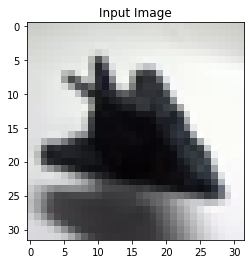

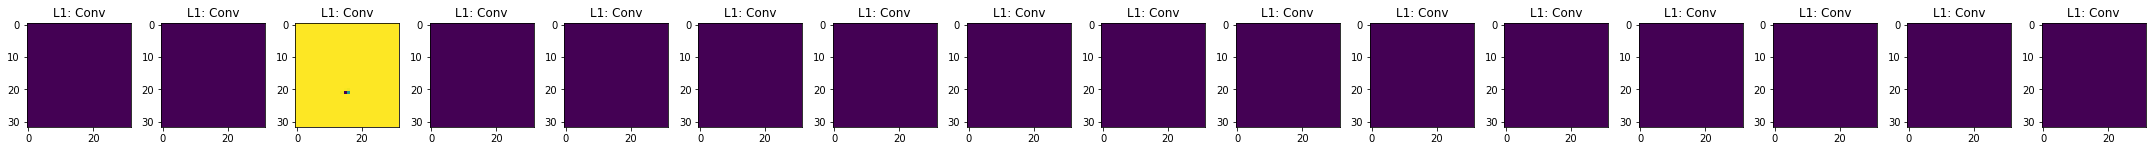

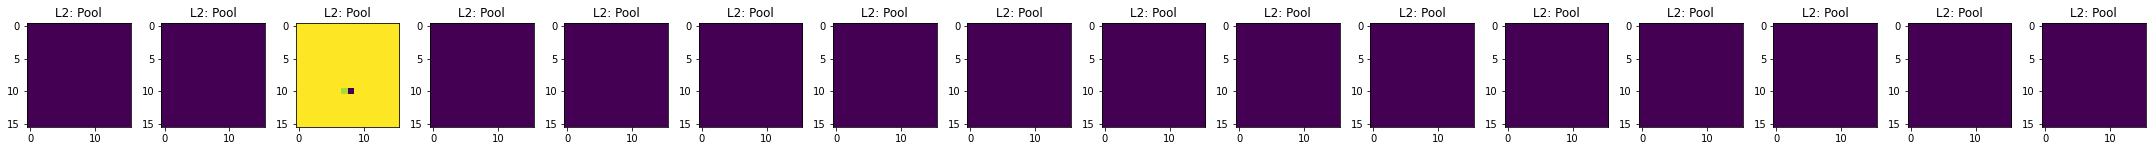

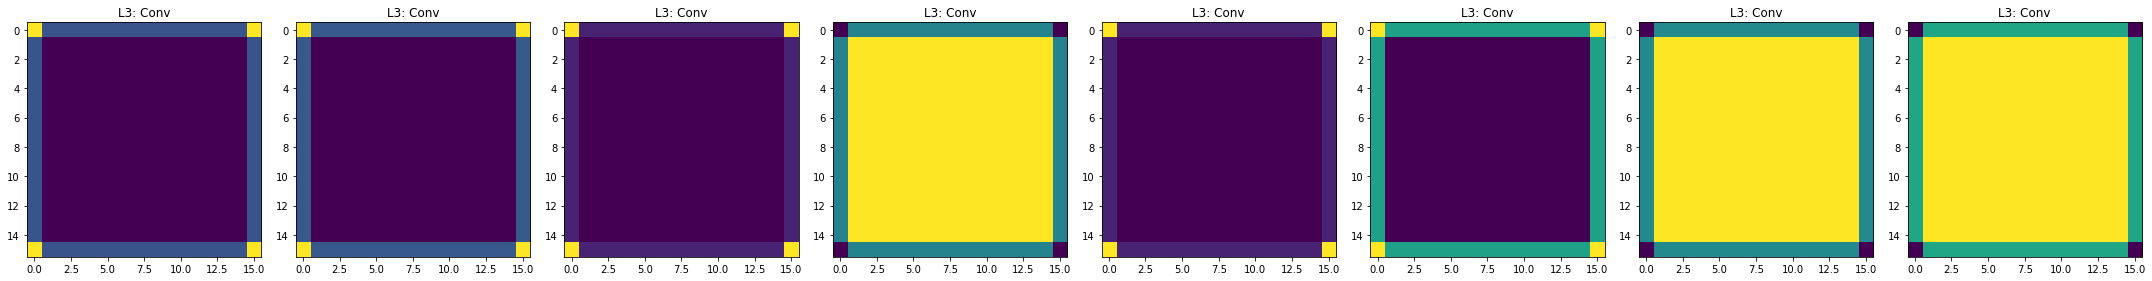

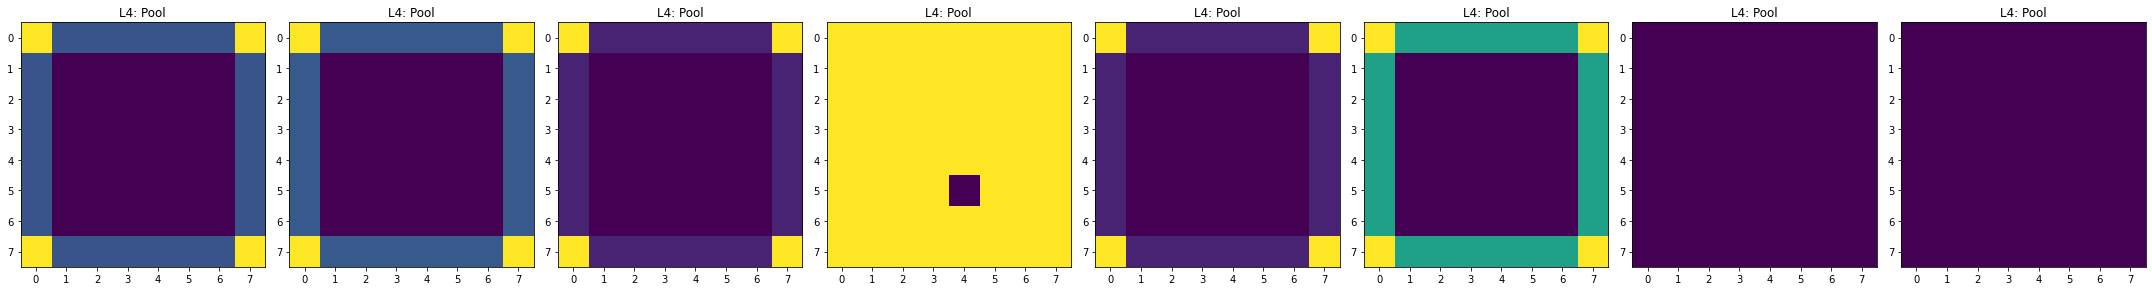

In [ ]:
I, label = dataset[int(image_indices[0, 0])]
I = np.array(I)
print("Class:", labels_map[label])
l1, l2, l3, l4, l5, l6 = forward(I, plot=True, kernel="Random")

#### Class 2

Class: car
Shapes/dimensions of all the layers
Input image: (32, 32, 3)
Convolution layer 1: (16, 32, 32)
Pooling layer 1: (16, 16, 16)
Convolution layer 2: (8, 16, 16)
Pooling layer 2: (8, 8, 8)
Flattened layer: (512,)
Output vector: (1, 10)

The output vector:
 [[1.35825282e-058 6.62494665e-102 1.00000000e+000 1.00000000e+000
  1.54320184e-114 1.74858178e-111 1.00000000e+000 1.00000000e+000
  1.00000000e+000 1.01134871e-005]]


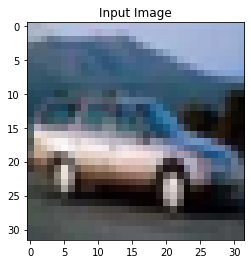

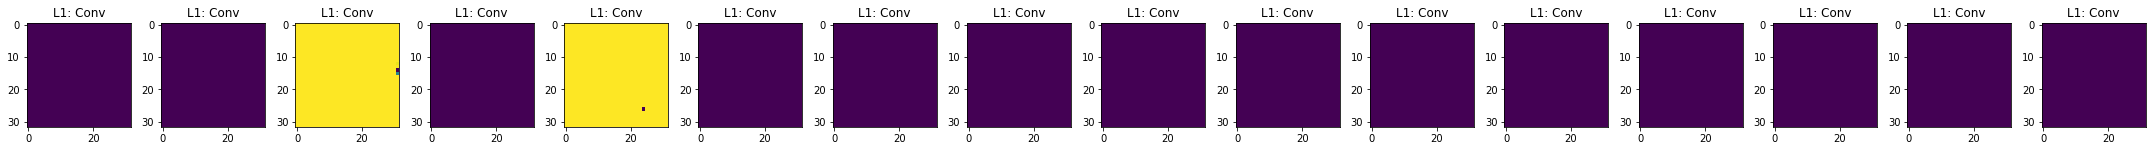

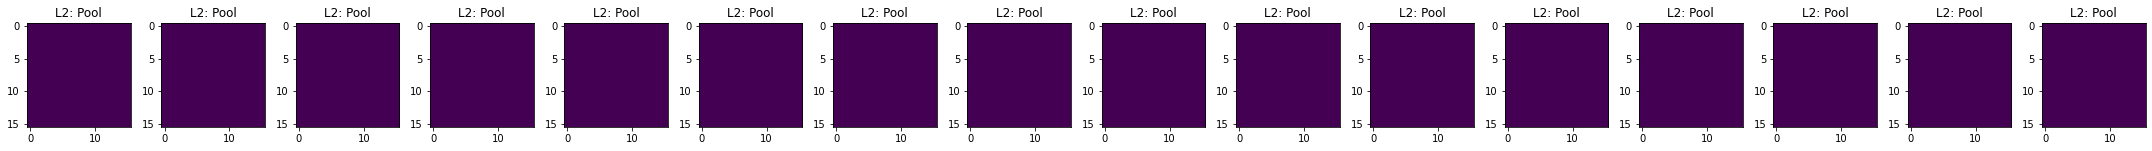

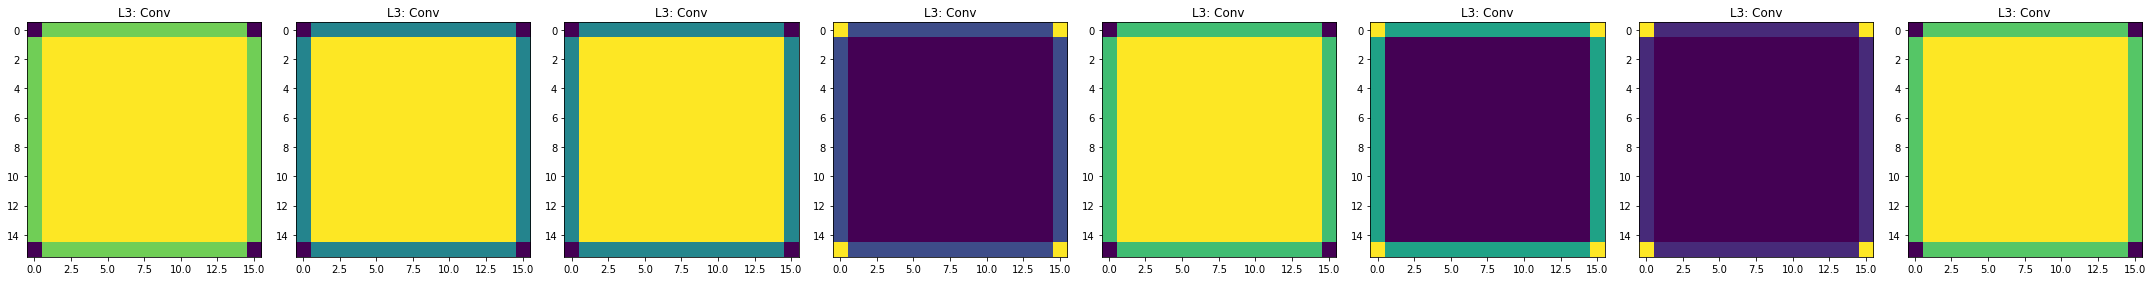

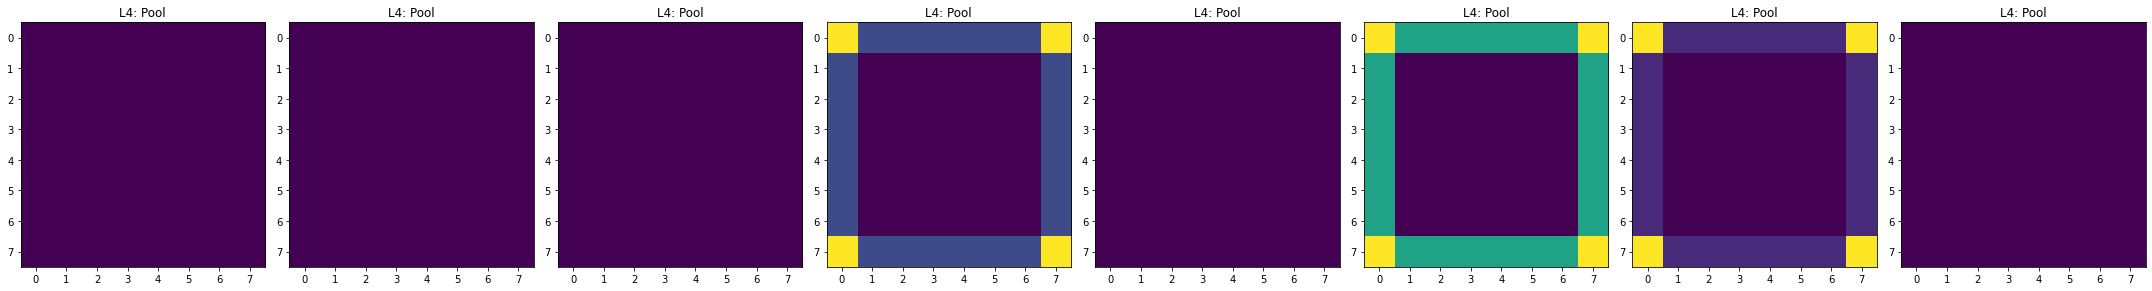

In [ ]:
I, label = dataset[int(image_indices[1, 0])]
I = np.array(I)
print("Class:", labels_map[label])
l1, l2, l3, l4, l5, l6 = forward(I, plot=True, kernel="Random")

#### Class 3

Class: bird
Shapes/dimensions of all the layers
Input image: (32, 32, 3)
Convolution layer 1: (16, 32, 32)
Pooling layer 1: (16, 16, 16)
Convolution layer 2: (8, 16, 16)
Pooling layer 2: (8, 8, 8)
Flattened layer: (512,)
Output vector: (1, 10)

The output vector:
 [[2.14138849e-070 3.85408496e-013 1.00000000e+000 6.21946986e-002
  1.00000000e+000 1.00000000e+000 1.76892165e-178 1.00000000e+000
  1.03759132e-032 6.99622380e-014]]


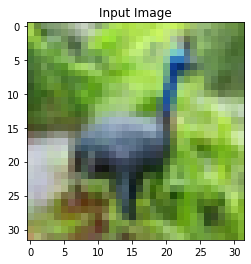

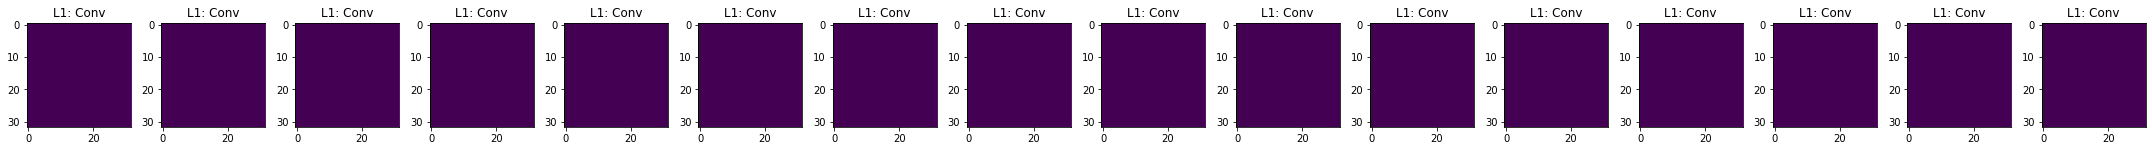

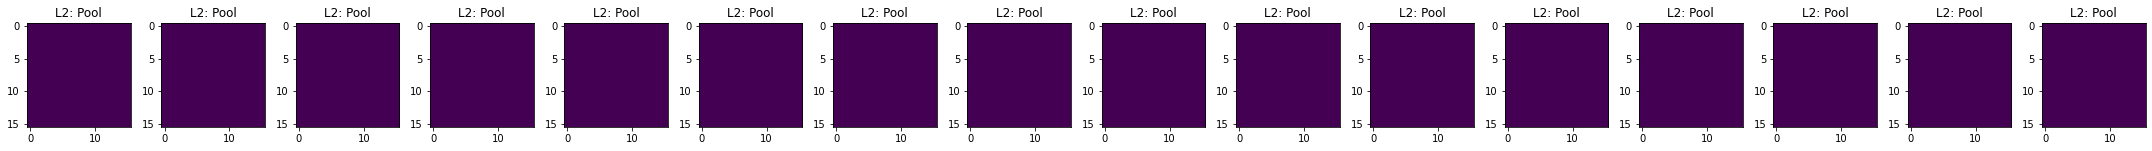

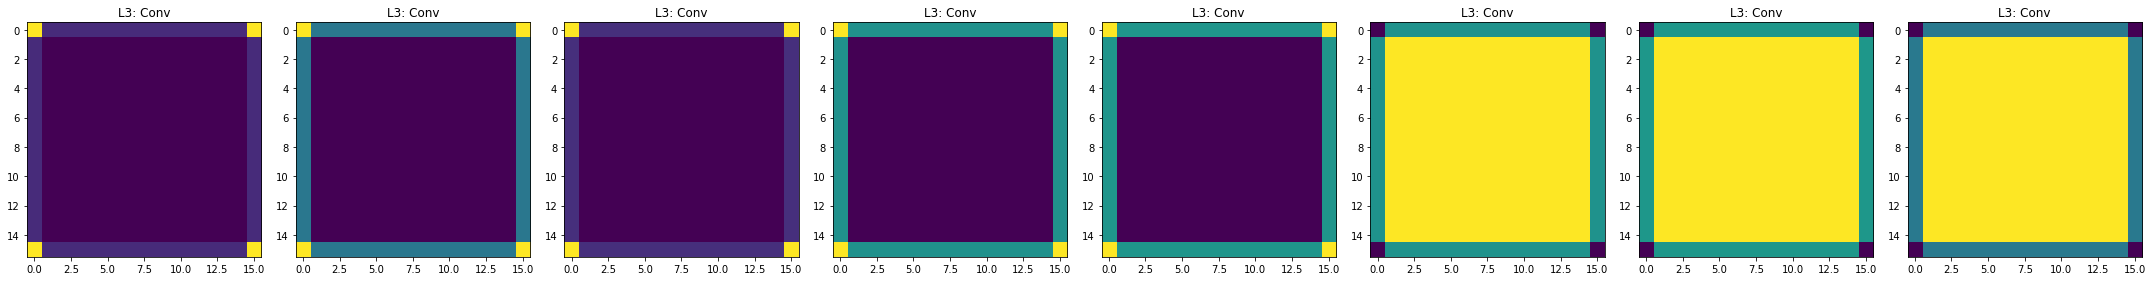

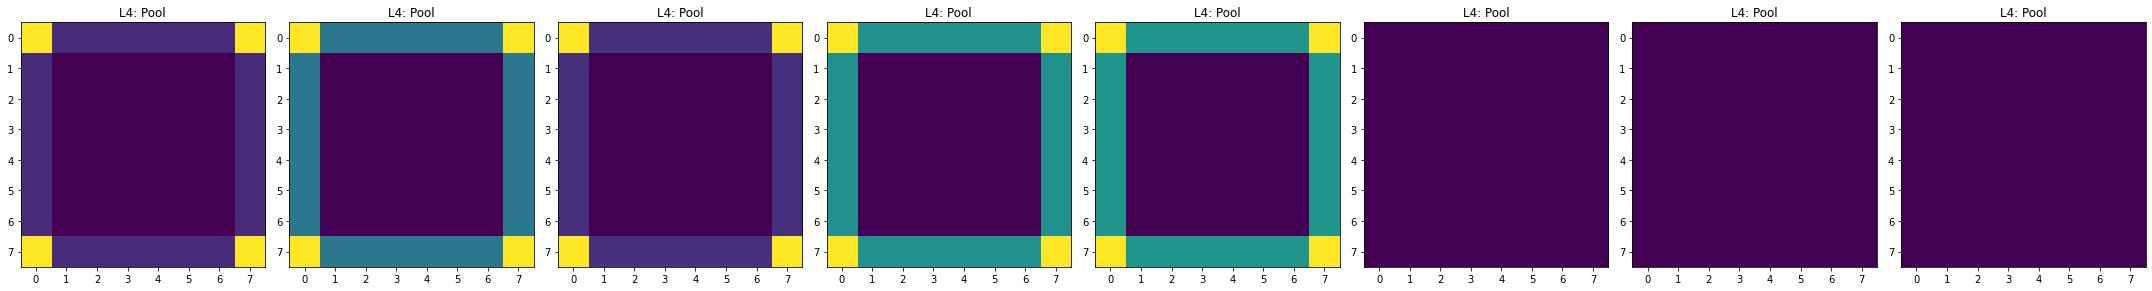

In [ ]:
I, label = dataset[int(image_indices[2, 0])]
I = np.array(I)
print("Class:", labels_map[label])
l1, l2, l3, l4, l5, l6 = forward(I, plot=True, kernel="Random")

#### Class 4

Class: cat
Shapes/dimensions of all the layers
Input image: (32, 32, 3)
Convolution layer 1: (16, 32, 32)
Pooling layer 1: (16, 16, 16)
Convolution layer 2: (8, 16, 16)
Pooling layer 2: (8, 8, 8)
Flattened layer: (512,)
Output vector: (1, 10)

The output vector:
 [[1.00000000e+00 1.00000000e+00 4.30657638e-24 3.34244095e-27
  4.17751643e-55 1.00000000e+00 1.00000000e+00 9.89601202e-61
  1.00000000e+00 2.15151573e-76]]


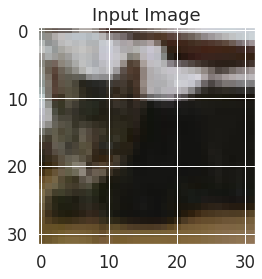

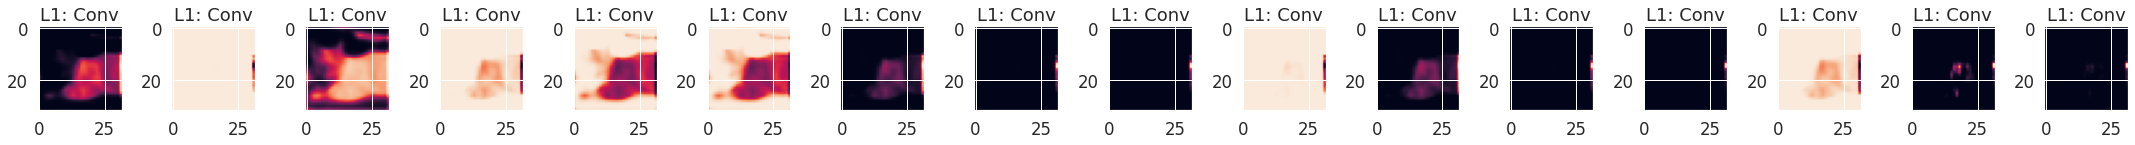

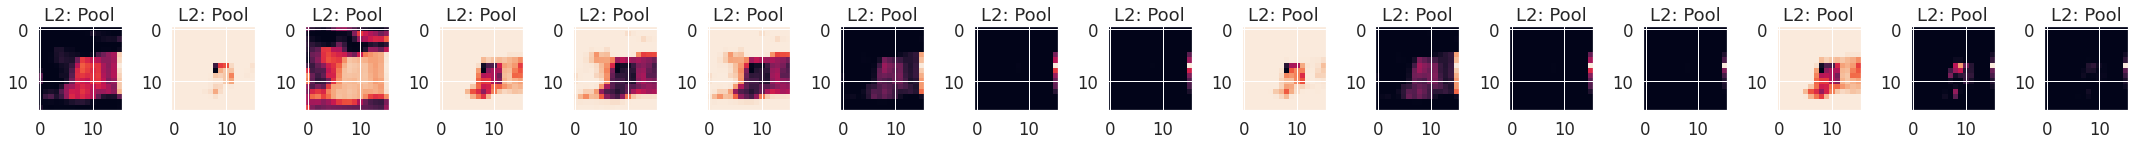

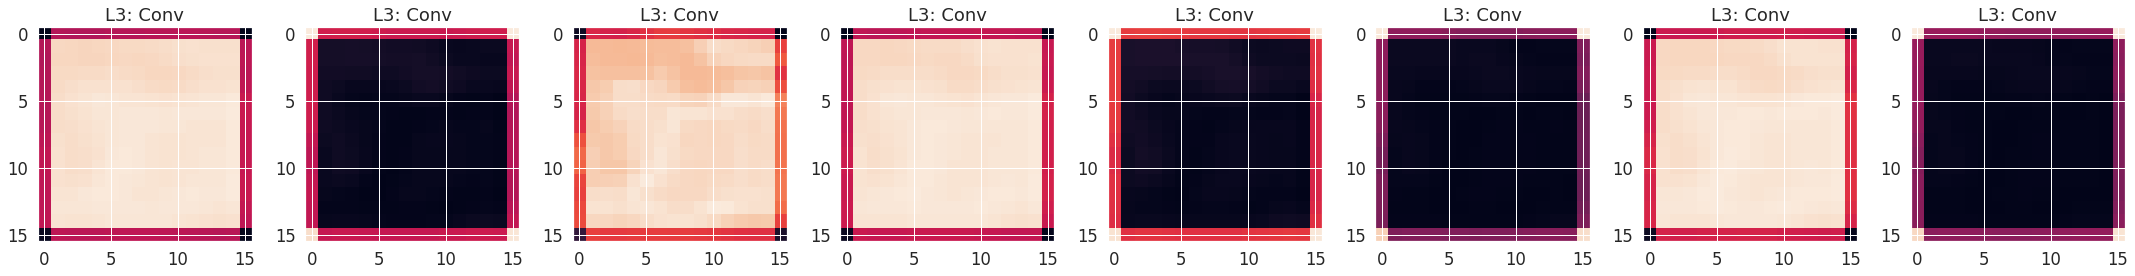

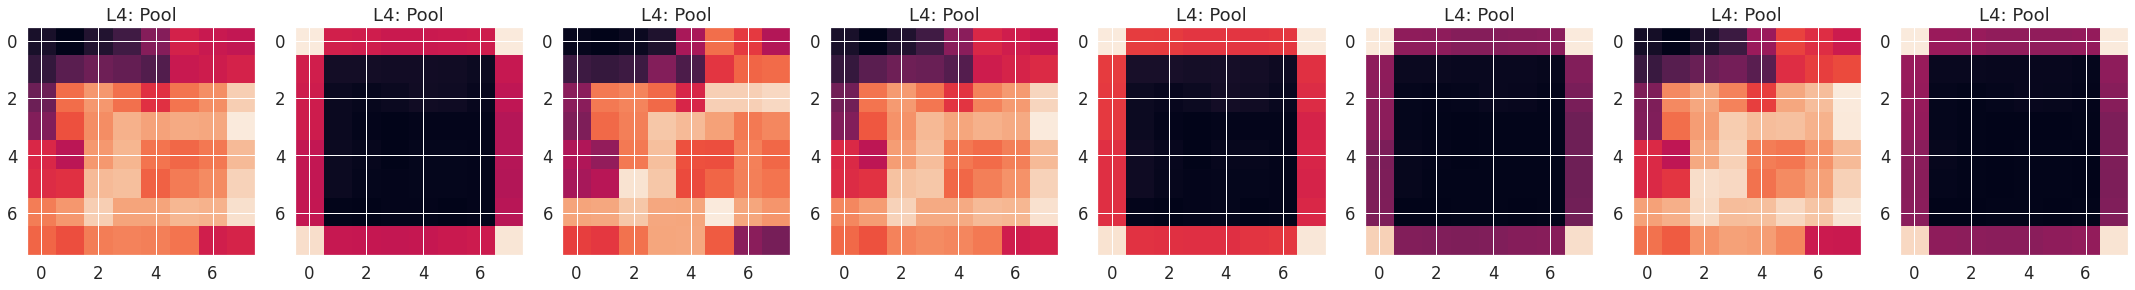

In [ ]:
I, label = dataset[int(image_indices[3, 0])]
I = np.array(I)
print("Class:", labels_map[label])
l1, l2, l3, l4, l5, l6 = forward(I, plot=True, kernel="Gaussian")

#### Class 5

Class: deer
Shapes/dimensions of all the layers
Input image: (32, 32, 3)
Convolution layer 1: (16, 32, 32)
Pooling layer 1: (16, 16, 16)
Convolution layer 2: (8, 16, 16)
Pooling layer 2: (8, 8, 8)
Flattened layer: (512,)
Output vector: (1, 10)

The output vector:
 [[5.56829268e-116 1.00000000e+000 4.66887689e-075 1.00000000e+000
  1.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
  3.13020291e-087 1.00000000e+000]]


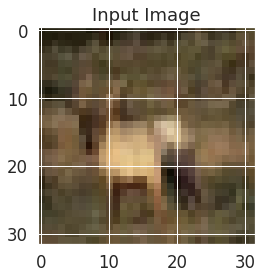

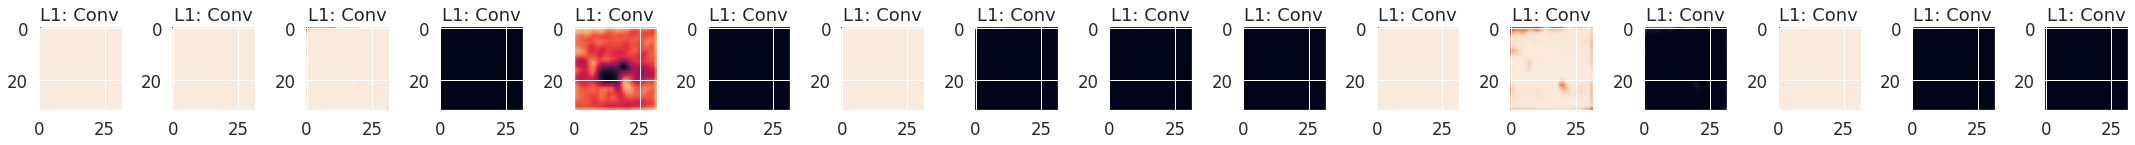

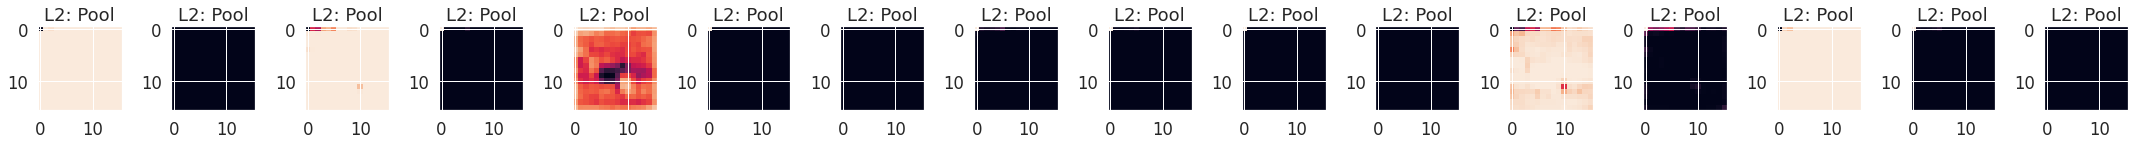

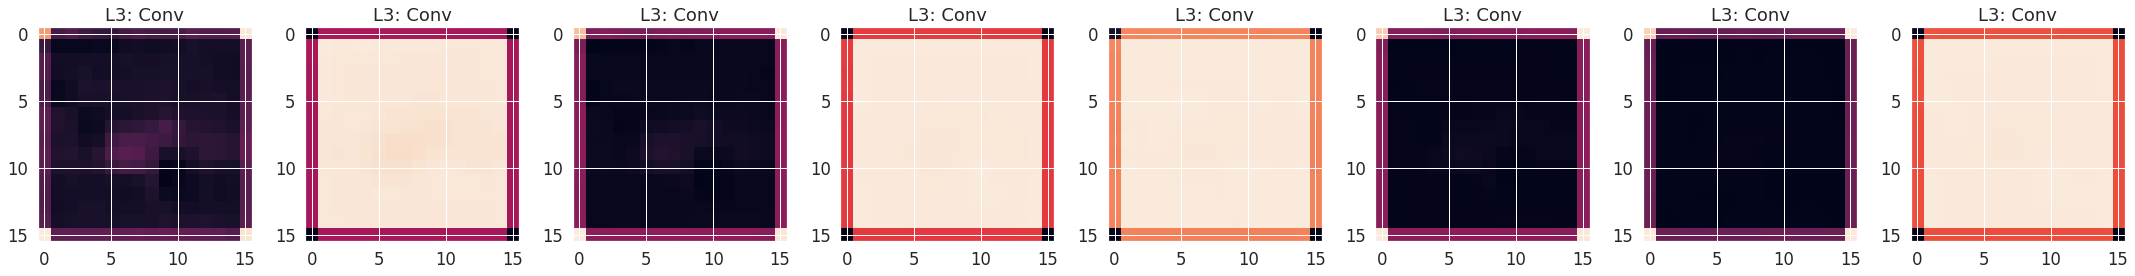

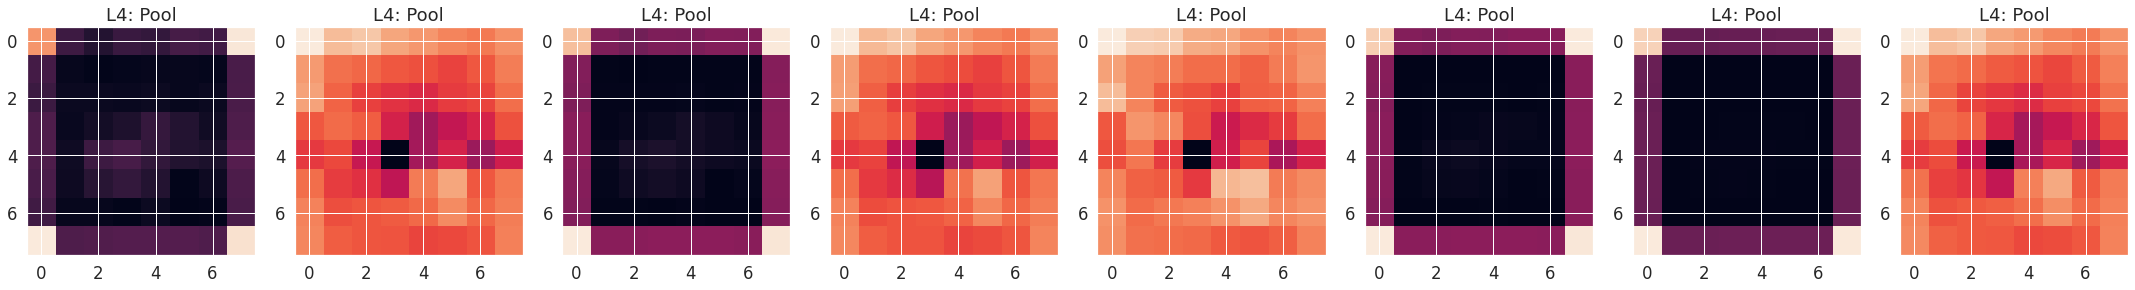

In [ ]:
I, label = dataset[int(image_indices[4, 0])]
I = np.array(I)
print("Class:", labels_map[label])
l1, l2, l3, l4, l5, l6 = forward(I, plot=True, kernel="Gaussian")

#### Class 6

Class: dog
Shapes/dimensions of all the layers
Input image: (32, 32, 3)
Convolution layer 1: (16, 32, 32)
Pooling layer 1: (16, 16, 16)
Convolution layer 2: (8, 16, 16)
Pooling layer 2: (8, 8, 8)
Flattened layer: (512,)
Output vector: (1, 10)

The output vector:
 [[2.20903378e-073 1.00000000e+000 8.53307619e-017 1.49649643e-001
  1.00000000e+000 1.00000000e+000 3.02174513e-046 1.60757347e-046
  5.34297855e-141 1.00000000e+000]]


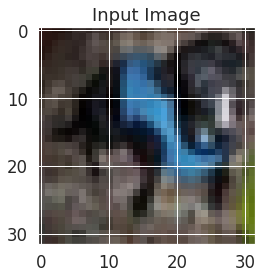

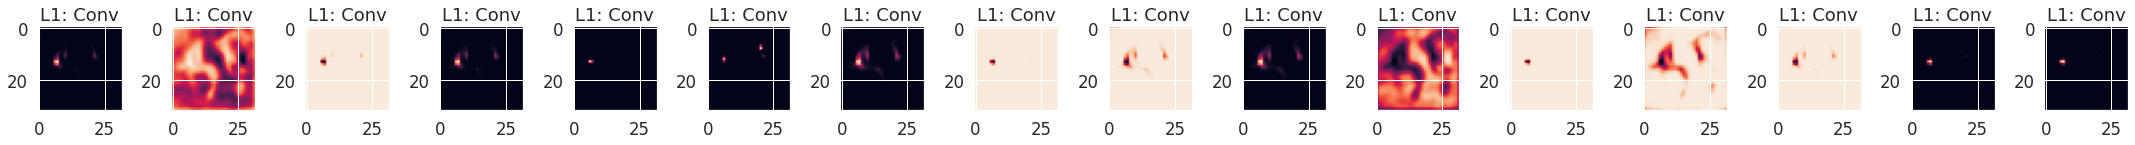

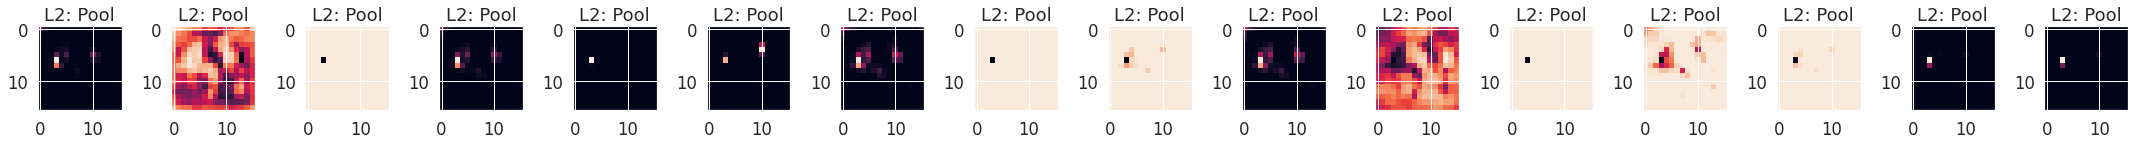

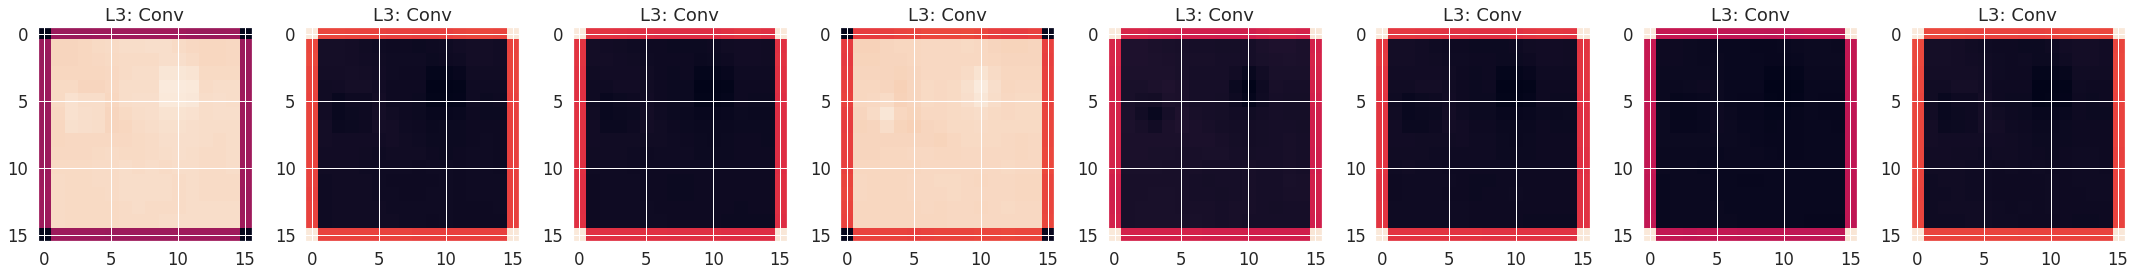

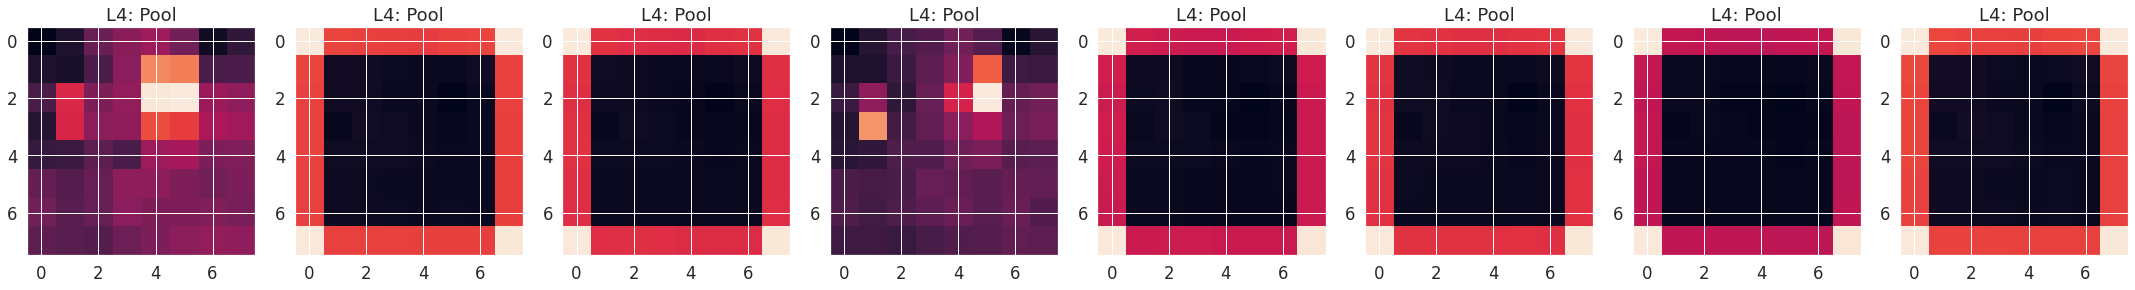

In [ ]:
I, label = dataset[int(image_indices[5, 0])]
I = np.array(I)
print("Class:", labels_map[label])
l1, l2, l3, l4, l5, l6 = forward(I, plot=True, kernel="Gaussian")

#### Class 7

Class: frog
Shapes/dimensions of all the layers
Input image: (32, 32, 3)
Convolution layer 1: (16, 32, 32)
Pooling layer 1: (16, 16, 16)
Convolution layer 2: (8, 16, 16)
Pooling layer 2: (8, 8, 8)
Flattened layer: (512,)
Output vector: (1, 10)

The output vector:
 [[1.00000000e+000 4.93983588e-091 2.96810553e-014 1.00000000e+000
  9.09702637e-009 1.37809884e-106 1.11126555e-007 6.37859278e-122
  1.00000000e+000 1.00000000e+000]]


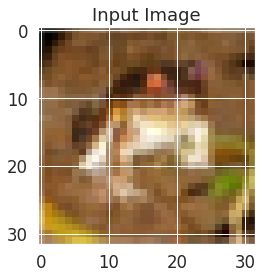

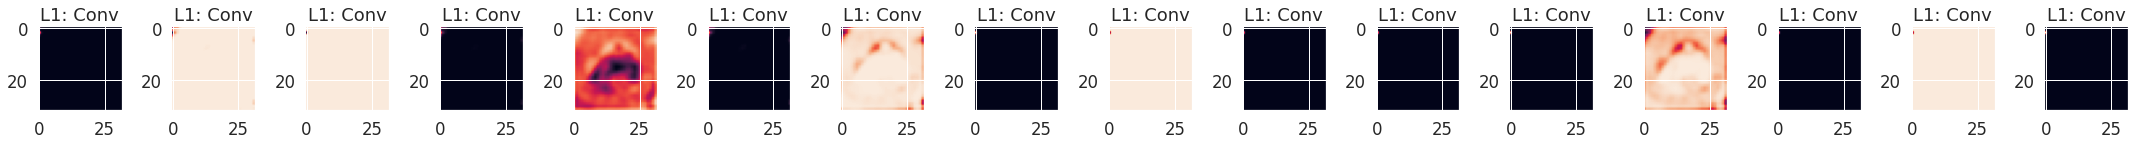

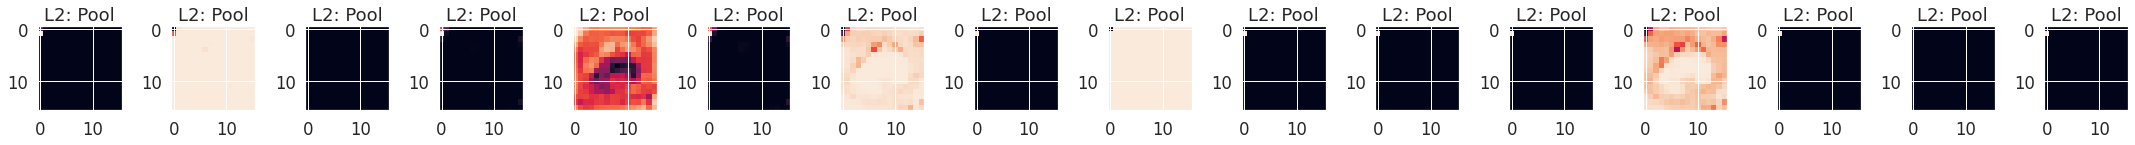

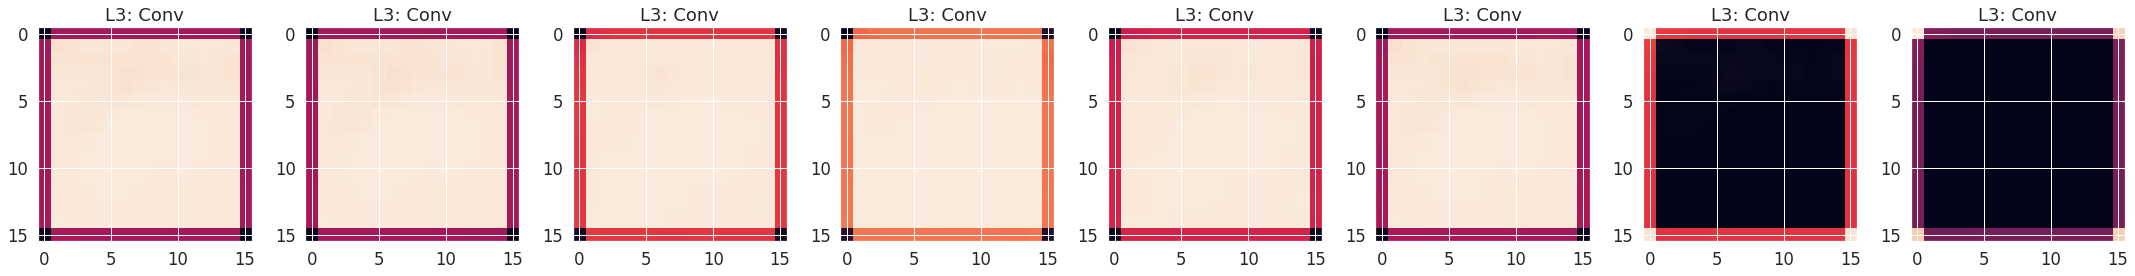

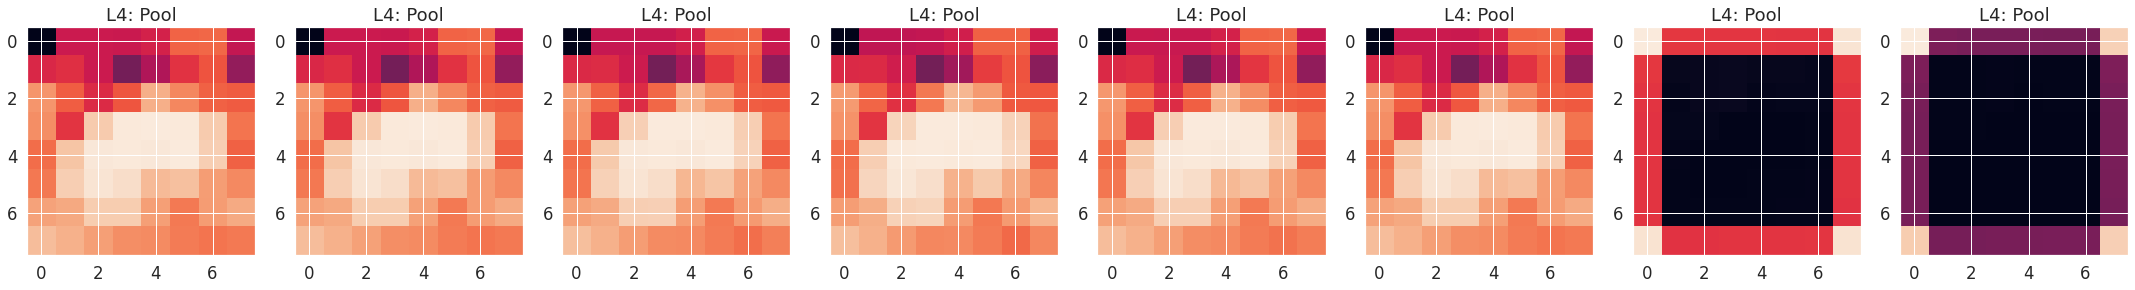

In [ ]:
I, label = dataset[int(image_indices[6, 0])]
I = np.array(I)
print("Class:", labels_map[label])
l1, l2, l3, l4, l5, l6 = forward(I, plot=True, kernel="Gaussian")

#### Class 8

Class: horse
Shapes/dimensions of all the layers
Input image: (32, 32, 3)
Convolution layer 1: (16, 32, 32)
Pooling layer 1: (16, 16, 16)
Convolution layer 2: (8, 16, 16)
Pooling layer 2: (8, 8, 8)
Flattened layer: (512,)
Output vector: (1, 10)

The output vector:
 [[1.00000000e+000 9.99999990e-001 6.41974370e-064 1.81158824e-045
  1.00000000e+000 1.57928567e-027 1.00000000e+000 1.00000000e+000
  3.17038590e-214 3.83746203e-046]]


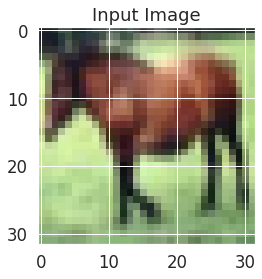

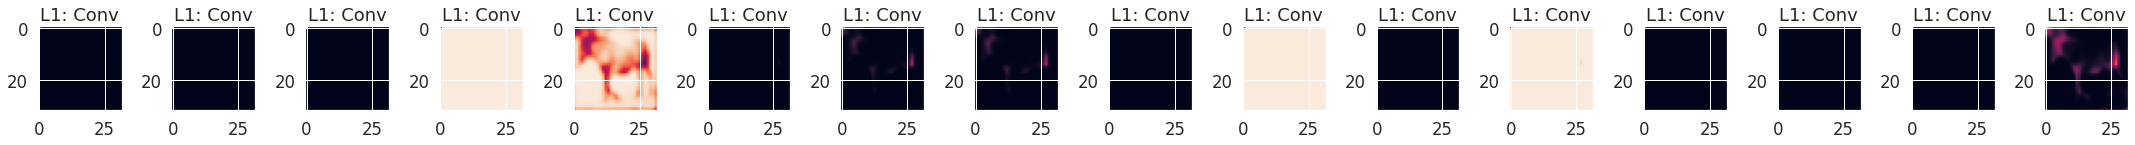

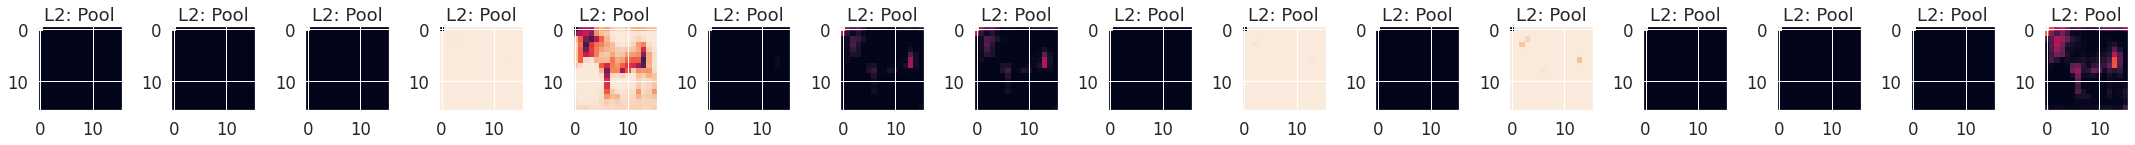

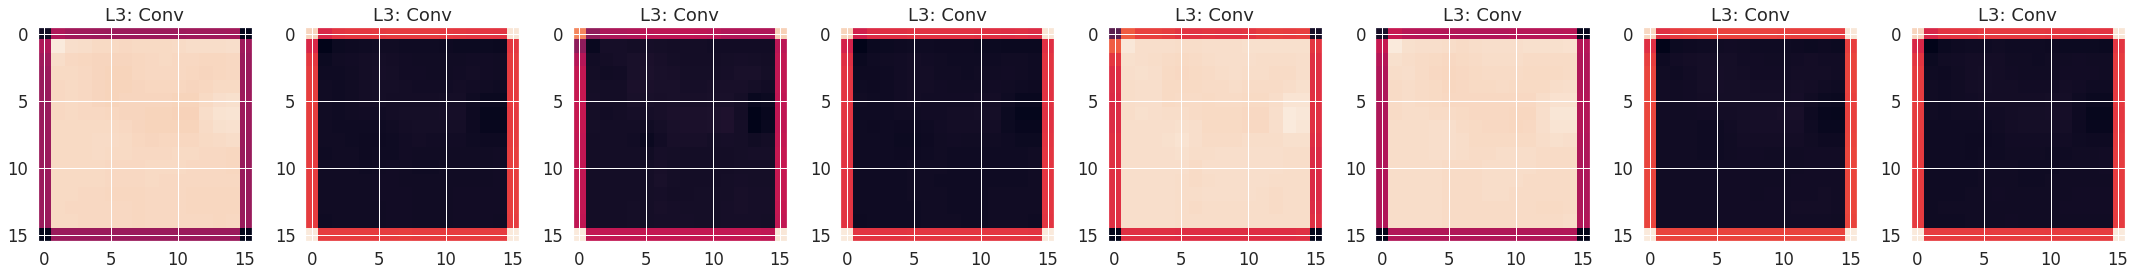

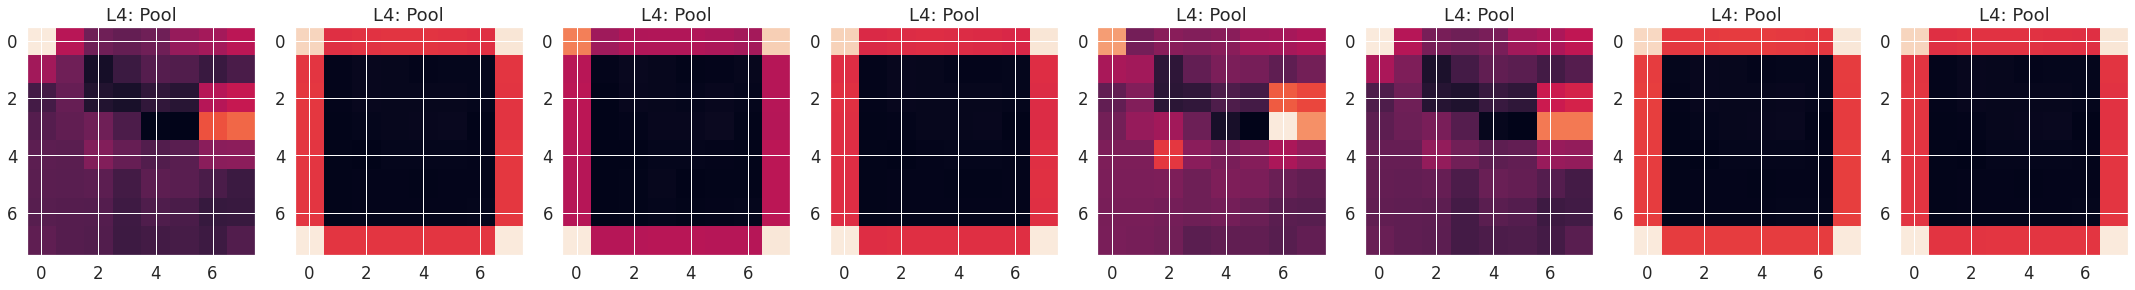

In [ ]:
I, label = dataset[int(image_indices[7, 0])]
I = np.array(I)
print("Class:", labels_map[label])
l1, l2, l3, l4, l5, l6 = forward(I, plot=True, kernel="Gaussian")

#### Class 9

Class: ship
Shapes/dimensions of all the layers
Input image: (32, 32, 3)
Convolution layer 1: (16, 32, 32)
Pooling layer 1: (16, 16, 16)
Convolution layer 2: (8, 16, 16)
Pooling layer 2: (8, 8, 8)
Flattened layer: (512,)
Output vector: (1, 10)

The output vector:
 [[1.00000000e+000 7.79474984e-201 7.70907493e-048 5.86916221e-120
  3.16826267e-065 8.44980013e-036 4.87945816e-097 7.14225833e-083
  1.00000000e+000 1.00000000e+000]]


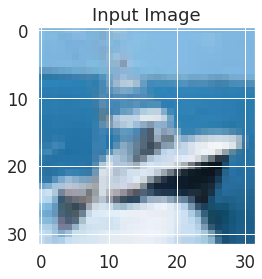

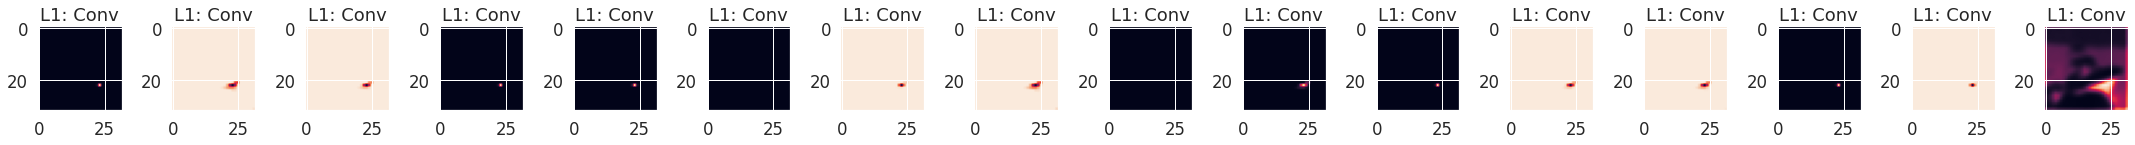

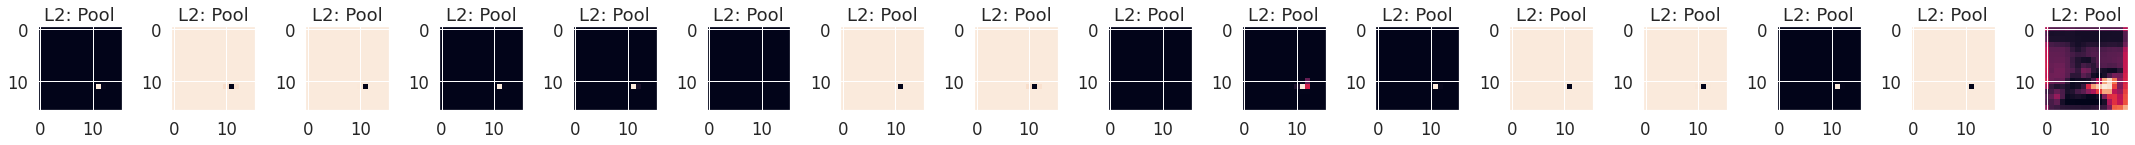

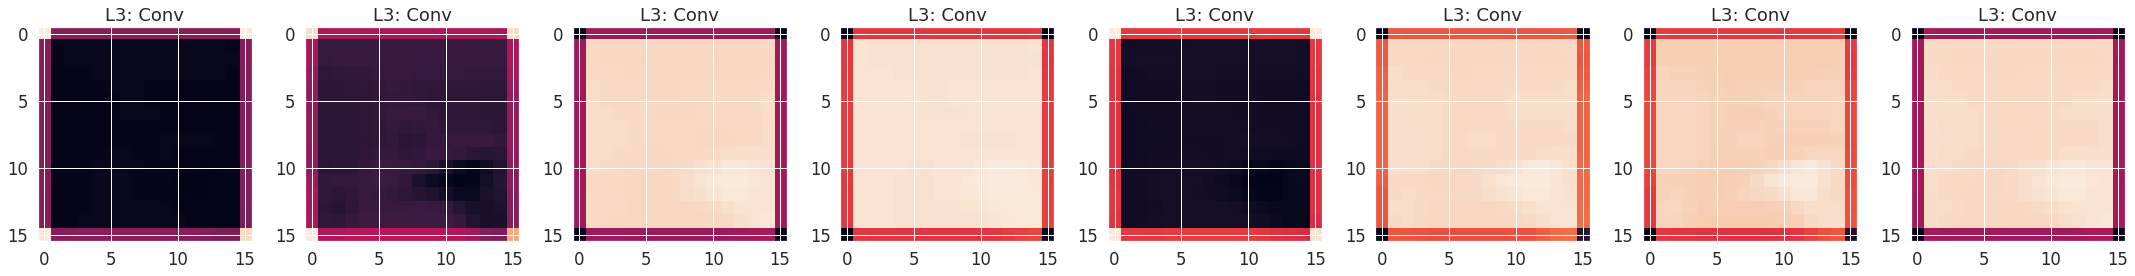

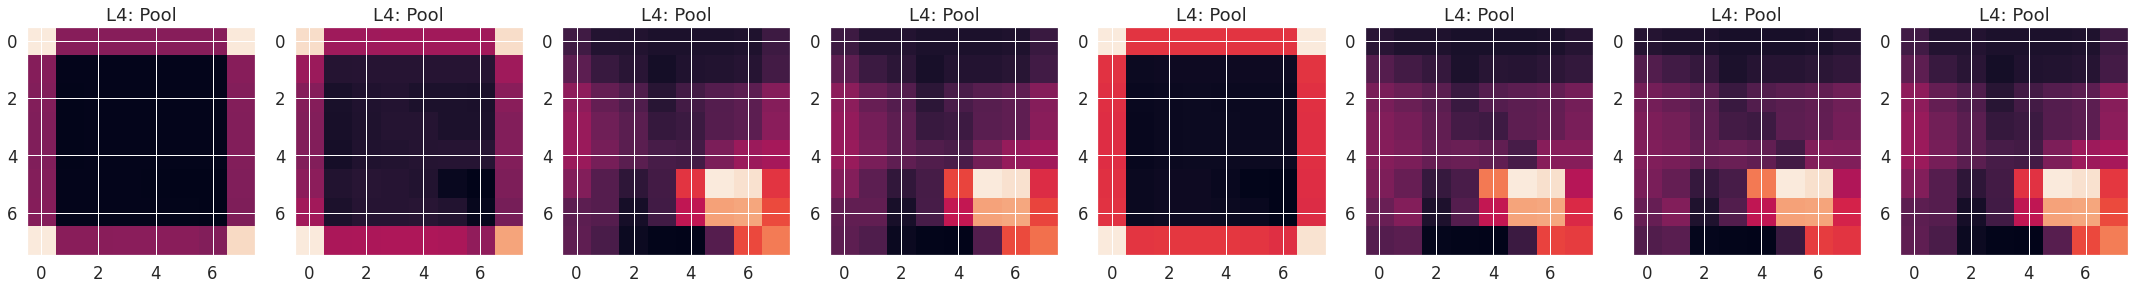

In [ ]:
I, label = dataset[int(image_indices[8, 0])]
I = np.array(I)
print("Class:", labels_map[label])
l1, l2, l3, l4, l5, l6 = forward(I, plot=True, kernel="Gaussian")

#### Class 10

Class: truck
Shapes/dimensions of all the layers
Input image: (32, 32, 3)
Convolution layer 1: (16, 32, 32)
Pooling layer 1: (16, 16, 16)
Convolution layer 2: (8, 16, 16)
Pooling layer 2: (8, 8, 8)
Flattened layer: (512,)
Output vector: (1, 10)

The output vector:
 [[6.43962191e-034 1.00000000e+000 1.00000000e+000 9.99725068e-001
  1.00000000e+000 8.33234745e-172 3.59183837e-012 1.00000000e+000
  2.86705250e-206 1.56926933e-034]]


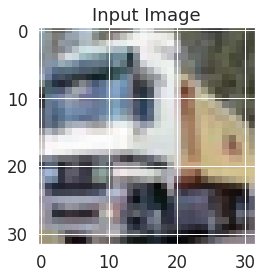

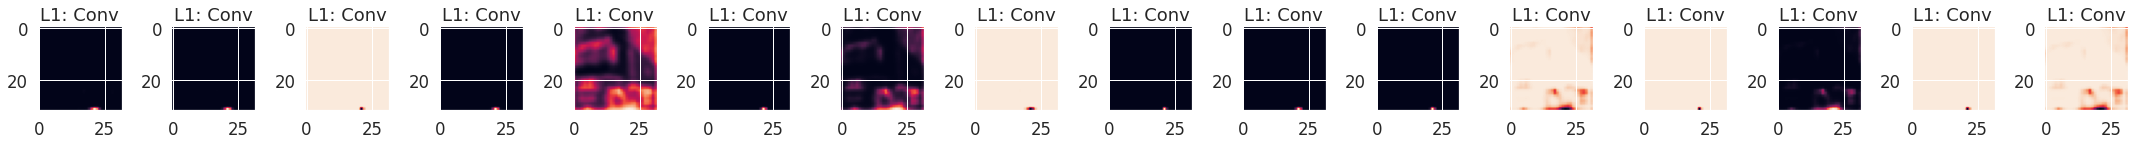

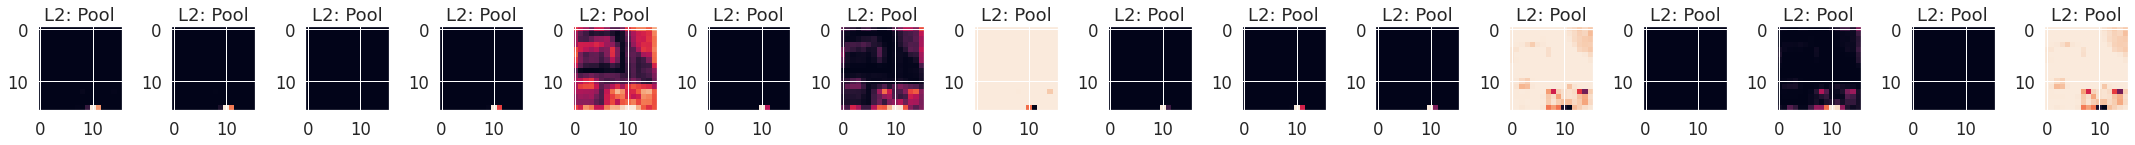

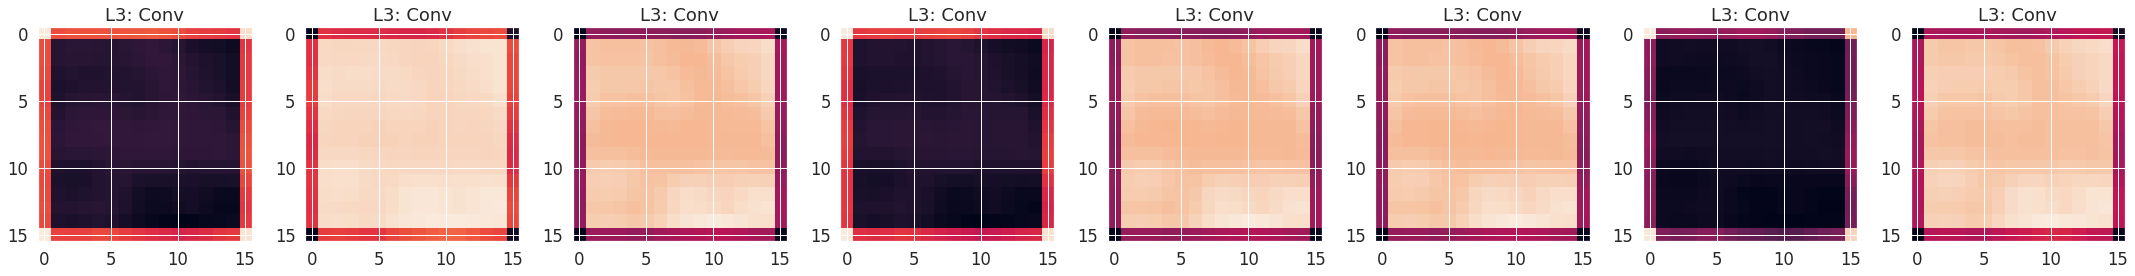

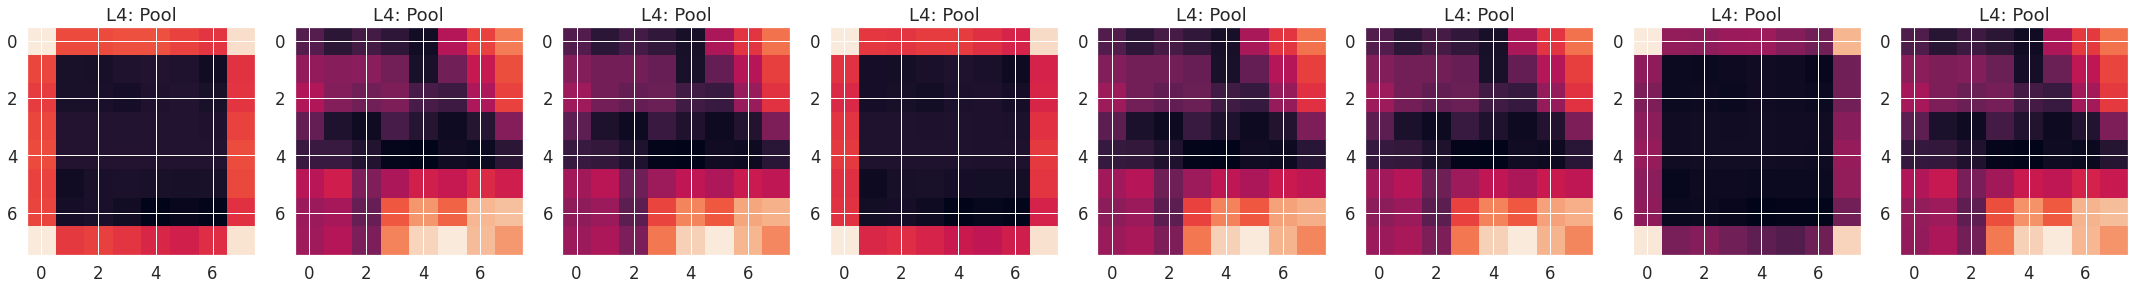

In [ ]:
I, label = dataset[int(image_indices[9, 0])]
I = np.array(I)
print("Class:", labels_map[label])
l1, l2, l3, l4, l5, l6 = forward(I, plot=True, kernel="Gaussian")

All the output vectors seem to have a lot of 1's in them.

### t-SNE Plots

In [ ]:
# The assignment document mentioned we are allowed to use open source code for the t-SNE plots.
# Hence, the t-SNE code was referenced from the following website: 
# https://www.datacamp.com/community/tutorials/introduction-t-sne

import matplotlib.patheffects as PathEffects

sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
RS = 123

def fashion_scatter(x, colors):
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    print(x.shape, x[:,0].shape, x[:,1].shape)

    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

Running the forward propagation for all 50 images

In [ ]:
classes = np.arange(10)
classes = np.repeat(classes, 3)
print(classes)

[0 0 0 1 1 1 2 2 2 3 3 3 4 4 4 5 5 5 6 6 6 7 7 7 8 8 8 9 9 9]


Shapes/dimensions of all the layers
Input image: (32, 32, 3)
Convolution layer 1: (16, 32, 32)
Pooling layer 1: (16, 16, 16)
Convolution layer 2: (8, 16, 16)
Pooling layer 2: (8, 8, 8)
Flattened layer: (512,)
Output vector: (1, 10)

The output vector:
 [[3.31257998e-029 1.44862903e-082 1.03370551e-271 3.14103438e-006
  1.00000000e+000 1.00000000e+000 9.80745898e-202 1.00000000e+000
  4.06499473e-125 4.26376526e-046]]
Shapes/dimensions of all the layers
Input image: (32, 32, 3)
Convolution layer 1: (16, 32, 32)
Pooling layer 1: (16, 16, 16)
Convolution layer 2: (8, 16, 16)
Pooling layer 2: (8, 8, 8)
Flattened layer: (512,)
Output vector: (1, 10)

The output vector:
 [[1.37735658e-072 3.72643685e-091 1.27595545e-036 2.41460604e-094
  1.00000000e+000 6.73540974e-201 1.00000000e+000 9.99997508e-001
  1.00000000e+000 3.45581947e-061]]
Shapes/dimensions of all the layers
Input image: (32, 32, 3)
Convolution layer 1: (16, 32, 32)
Pooling layer 1: (16, 16, 16)
Convolution layer 2: (8, 16, 16)


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


(30, 2) (30,) (30,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


(<Figure size 576x576 with 1 Axes>,
 [Text(57.08921, 5.2183056, '0'),
  Text(-77.8158, 48.499485, '1'),
  Text(25.037367, 8.140344, '2'),
  Text(-11.842884, 20.093239, '3'),
  Text(14.121401, -31.742874, '4'),
  Text(12.643576, 5.603182, '5'),
  Text(-18.71345, -14.154288, '6'),
  Text(-9.389013, 40.06551, '7'),
  Text(-34.273674, -7.3025527, '8'),
  Text(-35.43073, -14.3222685, '9')])

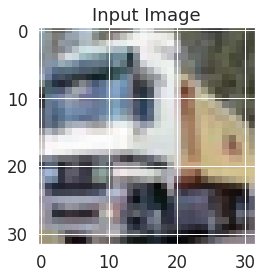

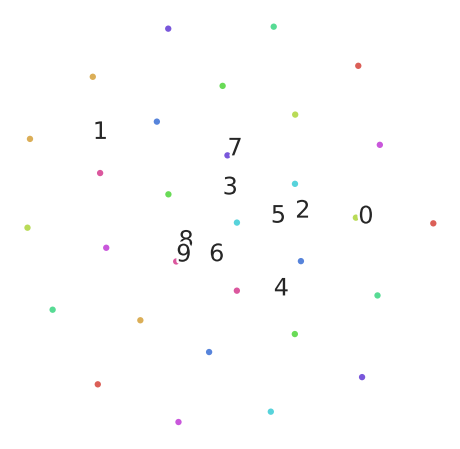

In [ ]:
random_filter = np.zeros((30, 512))

for i in range(image_indices.shape[0]):
  for j in range(image_indices.shape[1]):
    
    img, label = dataset[int(image_indices[i][j])]
    np_I = np.array(img)

    l1, l2, l3, l4, l5, l6 = forward(I, plot=False, kernel="Random")
    random_filter[i] = l5

tsne_random = TSNE(random_state=10).fit_transform(random_filter)
fashion_scatter(tsne_random, classes)